notebook 05a produced this figure originally but we decided best to hierarchically cluster all DE genes from both Excit and CIN together to make cross-cell-type comparisions better

In [1]:
# Built-in
import os
import math
import itertools
import multiprocessing
import statistics

# Analysis packages
import scanpy as sc
import anndata as ad
from adpbulk import ADPBulk
import numpy as np
import pandas as pd
import memento
from statsmodels.compat import lzip
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as scipystats
from sklearn.decomposition import PCA
from sklearn import manifold
import sklearn.cluster as clustering
from tslearn.clustering import KShape
import h5py

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.patheffects as path_effects
from pathlib import Path
import seaborn as sns
from adjustText import adjust_text

# Set number of cores to use
sc.settings.n_jobs = 8

sc.logging.print_header()

scanpy==1.10.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.0 scipy==1.13.1 pandas==1.5.3 scikit-learn==1.5.0 statsmodels==0.13.5 igraph==0.11.6 pynndescent==0.5.8


In [2]:
pd.set_option('display.max_columns', 40)

In [3]:
# Set autoreload settings. With this code,
# changing settings.py (see next cell) automatically loads the new settings in here too.
%load_ext autoreload
%autoreload 1

# Modify settings from this file (figure path, subsetting settings, etc)
# The file is located in this directory (settings.py)
%aimport settings

# Overhead

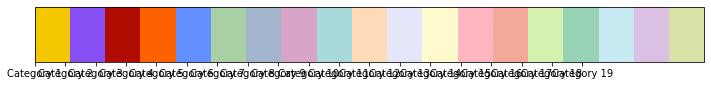

In [4]:
# Define the extended color list
colors_19 = [
    "#F4C700", "#8650F5", "#B00B00", "#FE6100", "#648FFF",
    "#A9CFA4", "#A3B5CC", "#D8A4C7", "#A8DADC", "#FFDAB9",
    "#E6E6FA", "#FFFACD", "#FFB6C1", "#F4A89A", "#D4F1B0",
    "#98D2B5", "#C7EAF2", "#DAC0E2", "#D9E3A8",
]

# Create a ListedColormap
custom_cmap = ListedColormap(colors_19)

# Display the colormap using a colorbar
fig, ax = plt.subplots(figsize=(12, 2))
fig.subplots_adjust(bottom=0.5)

# Create a colorbar with the custom cmap
cbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap=custom_cmap), 
    cax=ax, orientation='horizontal', ticks=[]
)

# Use the colors as category labels
cbar.set_ticks([i / 22.0 for i in range(len(colors_19))])
cbar.set_ticklabels([f'Category {i + 1}' for i in range(len(colors_19))])

# Display the colorbar
plt.show()

In [5]:
cluster_colors = colors_19[0:5]
color_order = ['L5-PT','IT','CIN-PV','CIN-SST','CIN-VIP']

In [6]:
def extend_limits(t, buffer=0.02):
    lower = t[0]
    upper = t[1]
    extension = buffer * (upper - lower)
    return (lower - extension, upper + extension)
extend_limits((0,2))

(-0.04, 2.04)

In [7]:
adata = sc.read("post-wt-clustering-with-markers.h5ad")
adata

AnnData object with n_obs × n_vars = 264420 × 24181
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'leiden', 'id', 'name', 'color'
    var: 'gene_name', 'gene_ids', 'feature_types', 'genome', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden', 'hvg', 'label_colors', 'label_colors_dict', 'label_order', 'log1p', 'name_colors', 'rank_genes_groups', 'scrublet', 'stage_colors_dict', 'stage_order'
    obsm: 'X_pca', 'X_umap'
    layers: 'ds_norm_cts', 'raw-cts_pre-ds'
    obsp: 'connectivities', 'distances'

In [8]:
dendro_ordered_cluster_ids = adata.uns['dendrogram_leiden']['categories_ordered']

In [9]:
drugs = ["none", "Ket", "Psilo"]
times = adata.uns["stage_order"]
clusters = ['0','1','2','3','4','5','6','7','8','9','10','12']
cluster_names = ['L2/3-IT','L6-CT','L4/5-IT','L4-IT',
                 'Oligodendrocytes','L5/6-IT','Astrocytes','L5-PT','CIN-PV',
                 'OPC','CIN-SST','CIN-VIP']

In [10]:
lump_excitatory = ['L2/3-IT','L6-CT','L4/5-IT','L4-IT','L5/6-IT','L5-PT']
lump_cin = ['CIN-PV','CIN-SST','CIN-VIP']

In [11]:
trt_drugs = drugs[1:]
trt_times = times[1:]

In [12]:
cluster_lookup = pd.DataFrame({'id':clusters, 'name':cluster_names})
cluster_lookup['id'] = pd.Categorical(cluster_lookup['id'], categories=dendro_ordered_cluster_ids, ordered=True)
cluster_lookup = cluster_lookup.sort_values('id')
cluster_lookup['name'] = pd.Categorical(cluster_lookup['name'], categories=cluster_lookup['name'], ordered=True)
cluster_lookup['color'] = adata.uns['name_colors']
cluster_lookup

,id,name,color
1,1,L6-CT,#A9CFA4
7,7,L5-PT,#F4C700
2,2,L4/5-IT,#8650F5
3,3,L4-IT,#4F19BE
0,0,L2/3-IT,#7662A0
5,5,L5/6-IT,#BA98FF
11,12,CIN-VIP,#648FFF
8,8,CIN-PV,#B00B00
10,10,CIN-SST,#FE6100
4,4,Oligodendrocytes,#A3B5CC


In [13]:
heatmap_idx = cluster_lookup['name'].to_list()
heatmap_cluster_labels = cluster_lookup.apply(lambda row: f"({row['id']}) {row['name']}", axis=1).to_list()

# Gene Clusterings

In [14]:
this_figure_dir = f'{settings.fig_path}/figure_6_split_PT'
os.makedirs(this_figure_dir, exist_ok=True)
os.makedirs(os.path.join(this_figure_dir, 'clustering_hyperparameters'), exist_ok=True)

In [15]:
# 0-1 inverse link functions
def logit(x):
    return 1 / (1 + np.exp(-x))

def cloglog(x):
    return 1 - np.exp(-np.exp(x))

# distance functions
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

def cosine_distance(a, b):
    return 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [16]:
pivot_cols = [f'{time}h' for time in trt_times]
pivot_cols

['1h', '2h', '4h', '24h', '72h']

## CIN data

In [17]:
cin_gene_progression = pd.DataFrame()
cin_significant_genes = set()
for time in trt_times:
    deg_results = pd.read_csv(os.path.join(settings.fig_path, 
                             f'figure_5/pseudobulk_clusters_counts/DEGs_CIN_{time}h_Psilo.csv'), 
                index_col=0)
    
    sig_results = deg_results[deg_results['FDR'] < 0.05].index.to_list()
    cin_significant_genes.update(set(sig_results)) 
    
    deg_results_series = deg_results['logFC'].rename(f'{time}h')
    cin_gene_progression = cin_gene_progression.join(deg_results_series, how='outer')

cin_gene_progression = cin_gene_progression.dropna()
cin_significant_gene_progression = cin_gene_progression.loc[cin_gene_progression.index.isin(cin_significant_genes)].copy()
cin_significant_gene_progression

,1h,2h,4h,24h,72h
0610030E20Rik,-0.492896,0.073616,-0.139450,0.035941,-0.254730
0610043K17Rik,-0.279517,0.228600,0.293762,-0.046003,-0.472453
1110008P14Rik,0.931890,0.012202,-0.162473,0.120335,0.140015
1110017D15Rik,-0.389174,-0.198722,-0.393501,-0.496028,-0.587892
1110032A03Rik,-0.258205,-0.187492,0.120077,0.208867,-0.436533
...,...,...,...,...,...
Zswim8,0.572511,-0.029266,-0.168740,0.033558,0.229561
Zup1,-0.390749,0.010462,-0.005944,0.056229,-0.142614
Zwint,0.435519,0.097039,-0.069796,0.359861,0.465942
Zyx,0.641607,0.247851,0.007734,0.545425,0.183665


## IT Excitatory data

In [18]:
excitatory_gene_progression = pd.DataFrame()
excitatory_significant_genes = set()
for time in trt_times:
    deg_results = pd.read_csv(os.path.join(settings.fig_path, 
                             f'figure_4/pseudobulk_clusters_counts/DEGs_{time}h_Psilo.csv'), 
                index_col=0)
    
    sig_results = deg_results[deg_results['FDR'] < 0.05].index.to_list()
    excitatory_significant_genes.update(set(sig_results)) 
    
    deg_results_series = deg_results['logFC'].rename(f'{time}h')
    excitatory_gene_progression = excitatory_gene_progression.join(deg_results_series, how='outer')

excitatory_gene_progression = excitatory_gene_progression.dropna()
excitatory_significant_gene_progression = excitatory_gene_progression.loc[excitatory_gene_progression.index.isin(excitatory_significant_genes)].copy()
excitatory_significant_gene_progression

,1h,2h,4h,24h,72h
0610005C13Rik,-0.966980,-0.532225,0.055773,-0.283119,-0.651763
0610009E02Rik,-0.671776,0.182791,-0.074826,-0.096543,-0.384217
0610040J01Rik,-0.958782,-0.042665,0.097850,-0.038166,-0.453873
1110002J07Rik,-0.838170,-0.851613,-0.692612,-0.311118,-0.960478
1110008P14Rik,0.816858,0.167199,-0.111294,0.179398,0.178292
...,...,...,...,...,...
Zswim9,-0.911119,-0.105069,0.062576,0.008388,-0.369649
Zwilch,-0.601756,-0.478886,-0.093522,-0.153348,-0.060739
Zxdb,0.425924,0.395030,0.063941,0.576772,0.607141
a,-0.578800,-0.193089,0.048169,-0.393151,-0.708127


## PT Excitatory data

In [19]:
pt_gene_progression = pd.DataFrame()
pt_significant_genes = set()
for time in trt_times:
    deg_results = pd.read_csv(os.path.join(settings.fig_path, 
                             f'figure_3/pseudobulk_clusters_counts/DEGs_{time}h_Psilo.csv'), 
                index_col=0)
    
    sig_results = deg_results[deg_results['FDR'] < 0.05].index.to_list()
    pt_significant_genes.update(set(sig_results)) 
    
    deg_results_series = deg_results['logFC'].rename(f'{time}h')
    pt_gene_progression = pt_gene_progression.join(deg_results_series, how='outer')

pt_gene_progression = pt_gene_progression.dropna()
pt_significant_gene_progression = pt_gene_progression.loc[pt_gene_progression.index.isin(pt_significant_genes)].copy()
pt_significant_gene_progression

,1h,2h,4h,24h,72h
0610030E20Rik,-0.419770,-0.065677,-0.117070,-0.048692,-0.520399
0610043K17Rik,-0.534370,-0.209384,0.103457,-0.343234,-0.485333
1110008P14Rik,0.554271,0.146886,-0.181282,0.266300,0.202009
1110017D15Rik,-0.500300,-0.329369,-0.505103,-0.259498,-0.555319
1110046J04Rik,-0.626413,-0.169113,0.006063,-0.414496,-0.788022
...,...,...,...,...,...
Zswim1,-0.627985,-0.205076,-0.472536,-0.284531,-0.198700
Zswim3,-0.679253,0.074972,-0.017399,0.107573,-0.269408
Zswim6,0.375756,0.042643,0.018271,-0.015059,0.276552
Zswim8,0.461900,0.017391,-0.138348,-0.037321,0.224822


## Combine and Cluster

In [20]:
cin_significant_gene_progression['celltype'] = 'CIN'
cin_significant_gene_progression = cin_significant_gene_progression.reset_index(names='gene')

excitatory_significant_gene_progression['celltype'] = 'IT'
excitatory_significant_gene_progression = excitatory_significant_gene_progression.reset_index(names='gene')

pt_significant_gene_progression['celltype'] = 'PT'
pt_significant_gene_progression = pt_significant_gene_progression.reset_index(names='gene')

master_significant_gene_progression = pd.concat([
    cin_significant_gene_progression, 
    excitatory_significant_gene_progression,
    pt_significant_gene_progression
])
master_significant_gene_progression

,gene,1h,2h,4h,24h,72h,celltype
0,0610030E20Rik,-0.492896,0.073616,-0.139450,0.035941,-0.254730,CIN
1,0610043K17Rik,-0.279517,0.228600,0.293762,-0.046003,-0.472453,CIN
2,1110008P14Rik,0.931890,0.012202,-0.162473,0.120335,0.140015,CIN
3,1110017D15Rik,-0.389174,-0.198722,-0.393501,-0.496028,-0.587892,CIN
4,1110032A03Rik,-0.258205,-0.187492,0.120077,0.208867,-0.436533,CIN
...,...,...,...,...,...,...,...
2224,Zswim1,-0.627985,-0.205076,-0.472536,-0.284531,-0.198700,PT
2225,Zswim3,-0.679253,0.074972,-0.017399,0.107573,-0.269408,PT
2226,Zswim6,0.375756,0.042643,0.018271,-0.015059,0.276552,PT
2227,Zswim8,0.461900,0.017391,-0.138348,-0.037321,0.224822,PT


In [21]:
master_significant_gene_progression['celltype'].value_counts()

IT     4934
CIN    3013
PT     2229
Name: celltype, dtype: int64

In [22]:
clustering_fit_data = master_significant_gene_progression[pivot_cols]

In [23]:
inertias = [ clustering.BisectingKMeans(n_clusters=i).fit(clustering_fit_data).inertia_
             for i in range(2,21)]

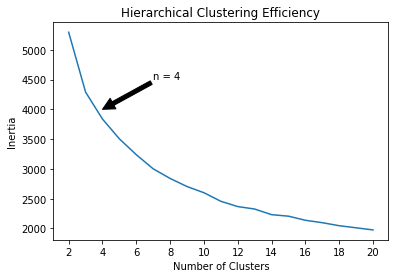

In [24]:
fig, ax = plt.subplots(1,1)
ax.plot(list(range(2,21)), inertias)
ax.annotate('n = 4', xy=(4,4000), xytext=(7,4500), arrowprops=dict(facecolor='black'))

ax.set(xlabel='Number of Clusters', ylabel='Inertia')
ax.set_title('Hierarchical Clustering Efficiency')
ax.set_xticks(np.arange(2,21,2))
plt.savefig(f'{this_figure_dir}/clustering_hyperparameters/bisectkmeans_inertia.png', dpi=600)
plt.savefig(f'{this_figure_dir}/clustering_hyperparameters/bisectkmeans_inertia.pdf', dpi=600)

0    5336
1    4840
Name: progression_group, dtype: int64
2    4840
0    3811
1    1525
Name: progression_group, dtype: int64
0    3695
2    3667
3    1669
1    1145
Name: progression_group, dtype: int64
4    3706
1    3570
0    1270
2     944
3     686
Name: progression_group, dtype: int64
4    3563
3    2354
2    1321
5    1277
1     983
0     678
Name: progression_group, dtype: int64
0    3570
2    1701
4    1600
1    1270
6     919
5     649
3     467
Name: progression_group, dtype: int64
6    3570
3    1430
5    1289
7    1270
0    1012
4    1001
1     524
2      80
Name: progression_group, dtype: int64


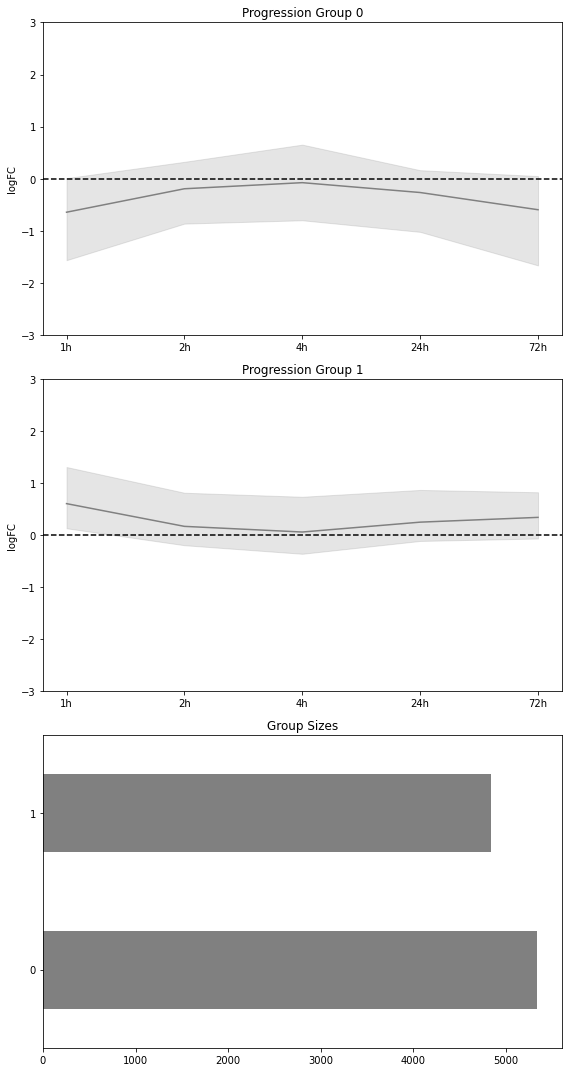

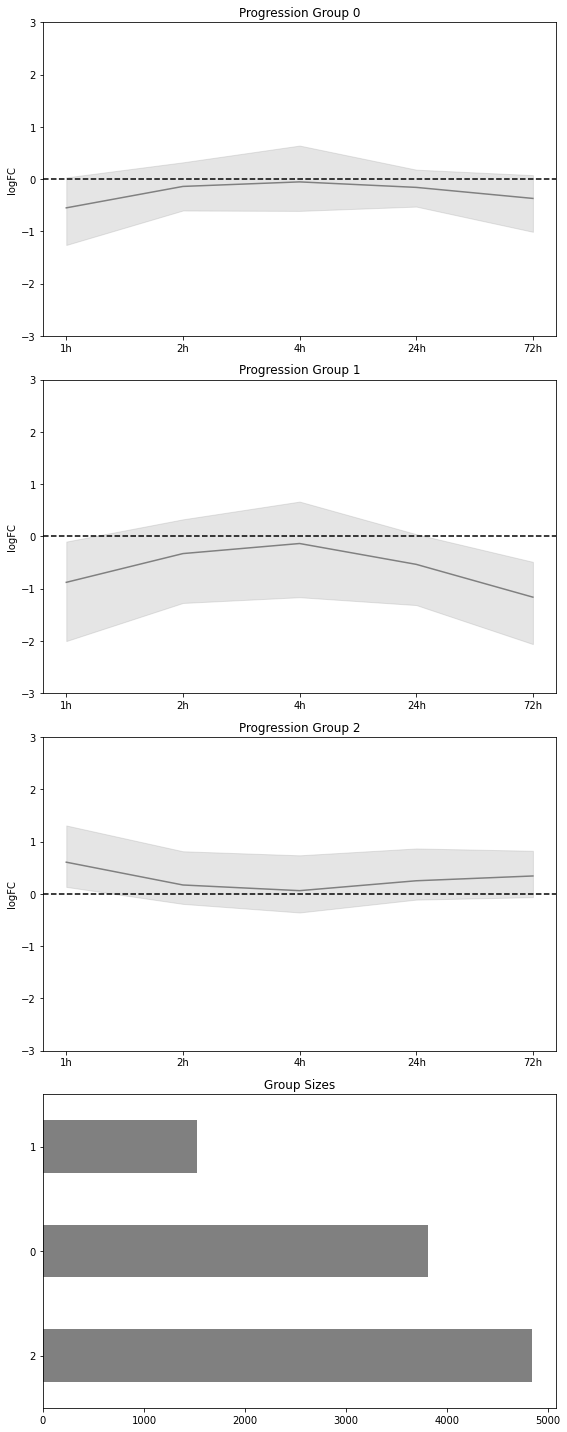

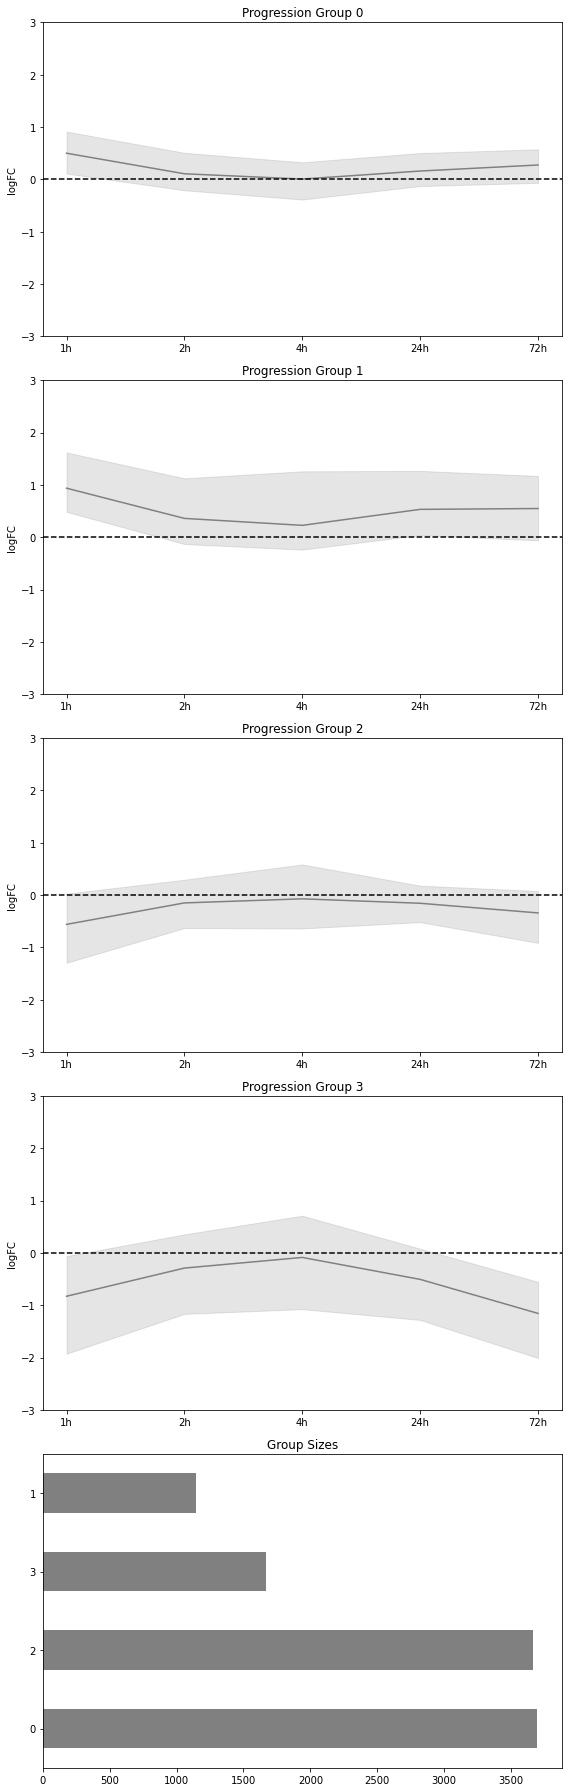

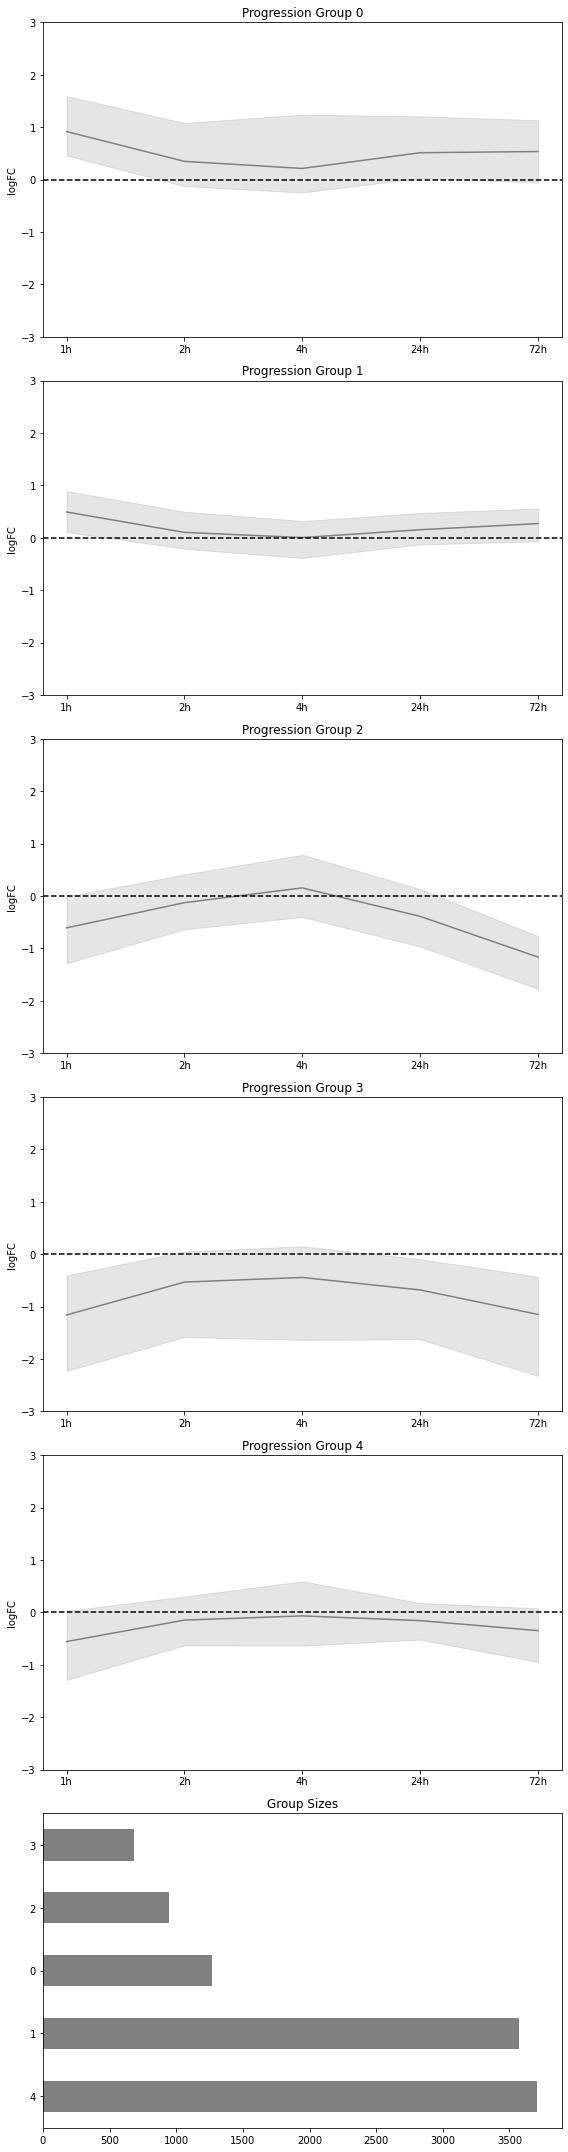

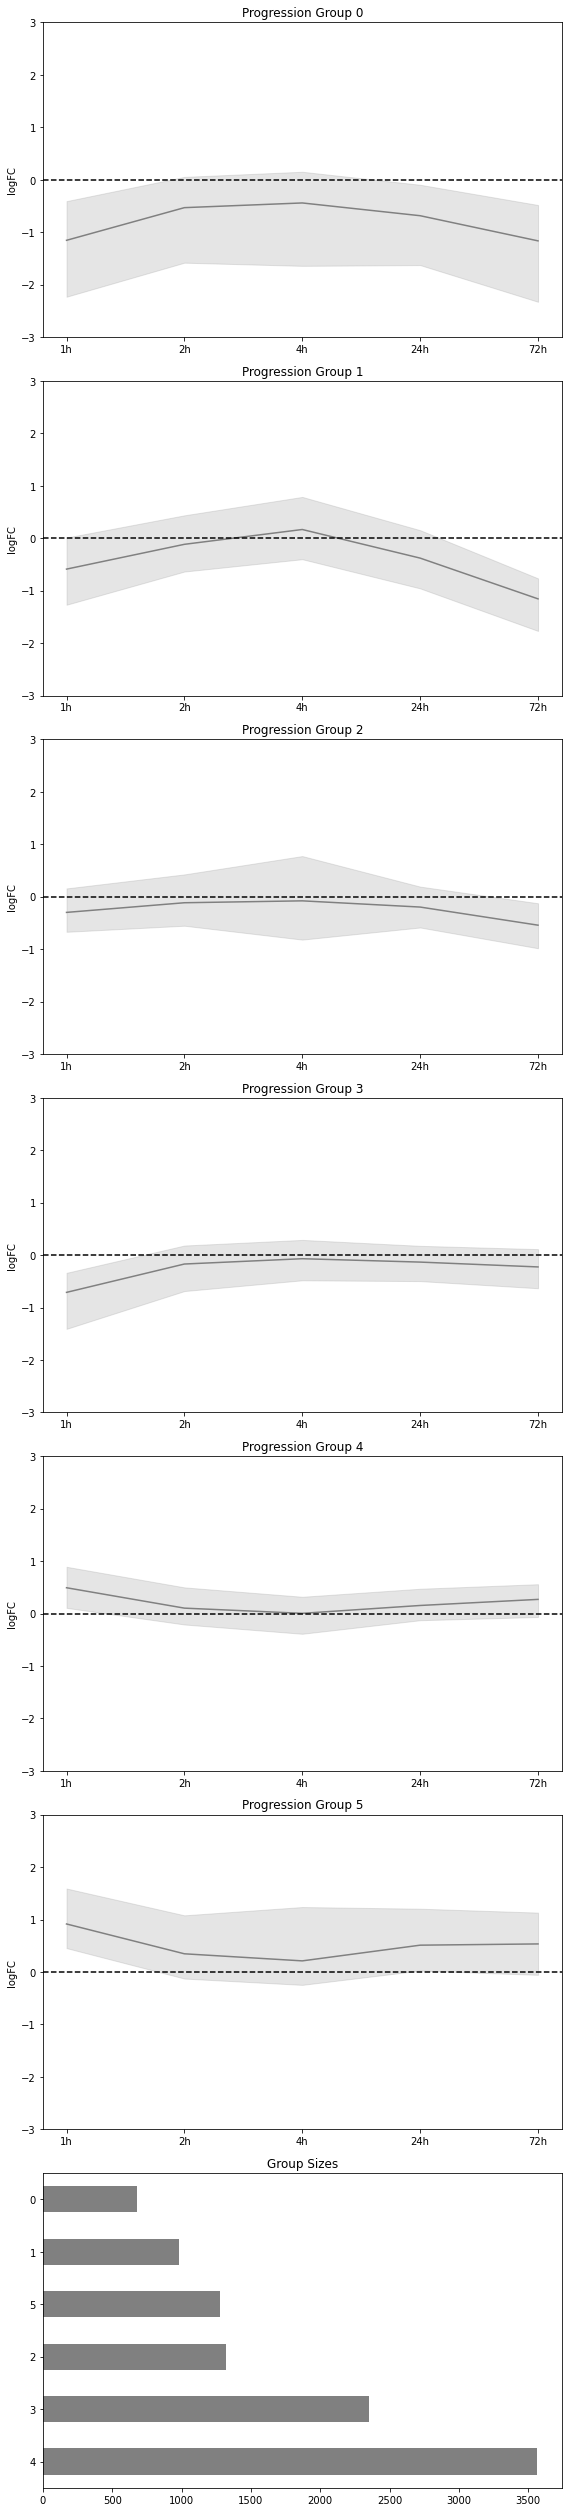

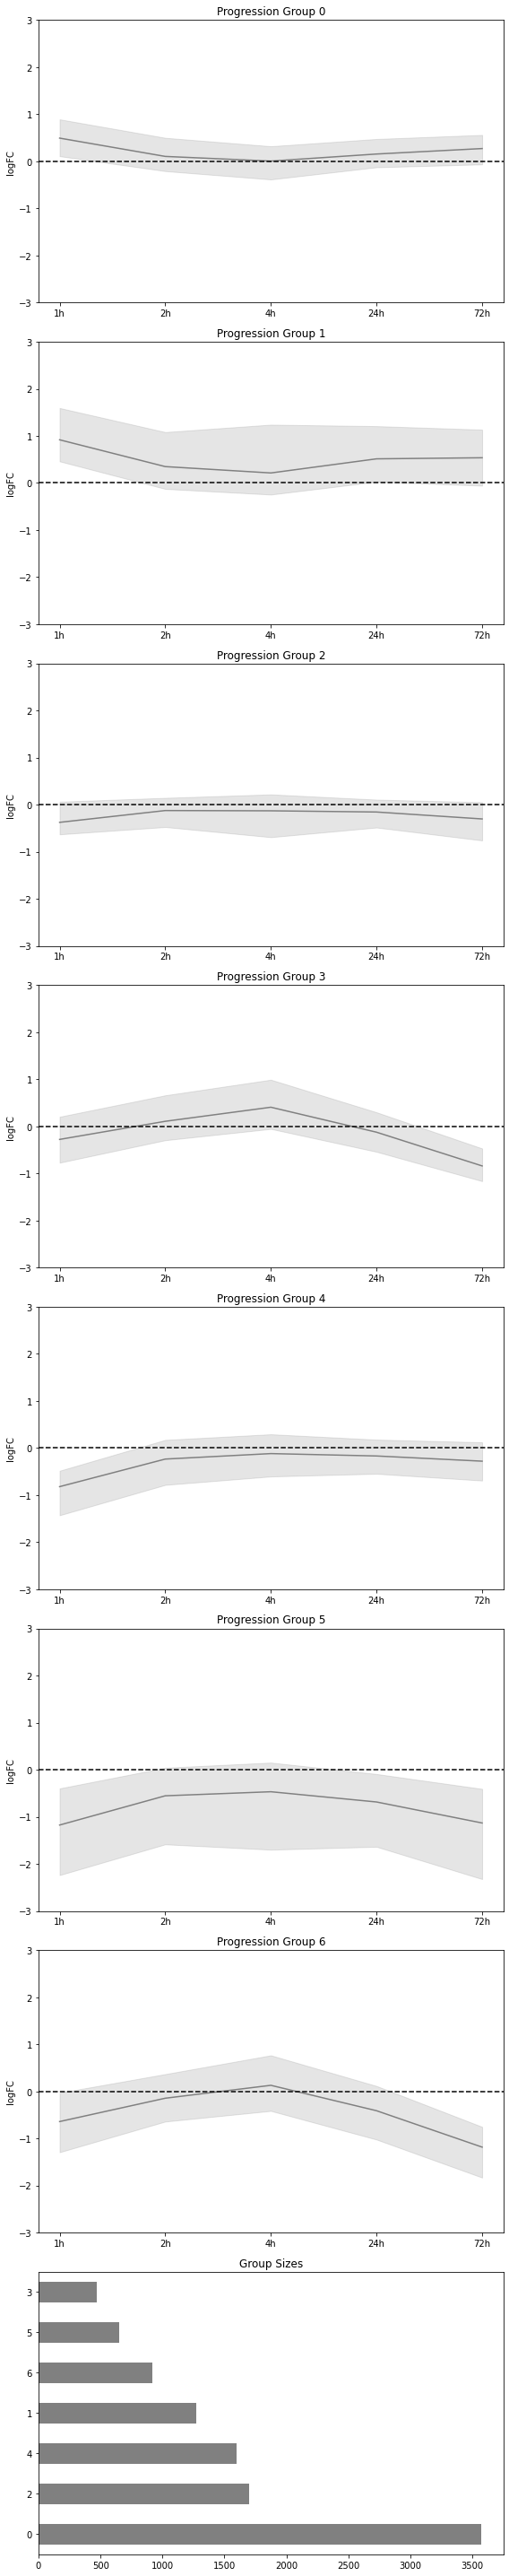

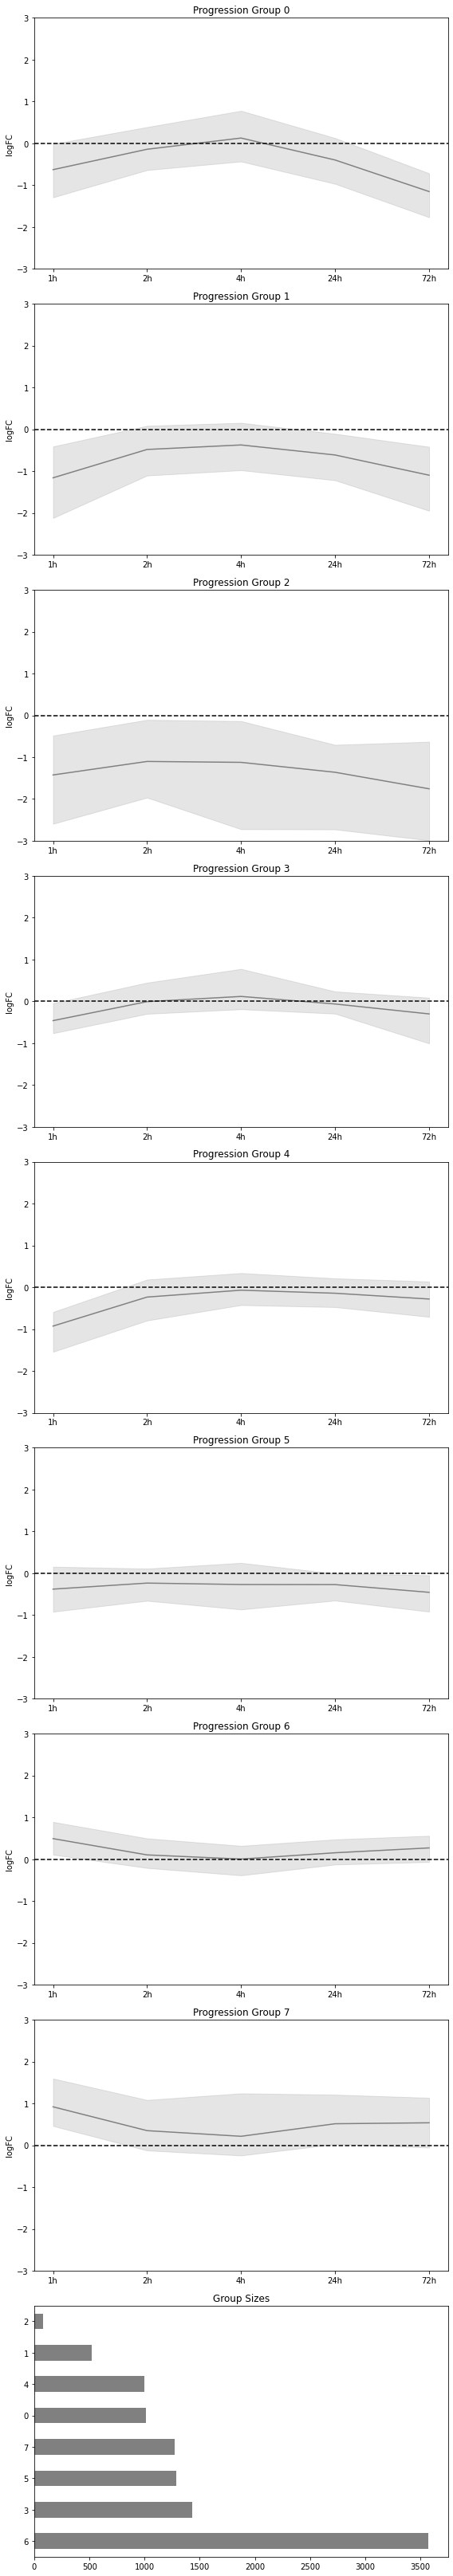

In [64]:
for i in range(2,9):
    significant_gene_progression = master_significant_gene_progression.copy()
    fit_hierarchical = clustering.BisectingKMeans(n_clusters=i).fit(clustering_fit_data)

    centroids = fit_hierarchical.cluster_centers_
    significant_gene_progression['progression_group'] = fit_hierarchical.labels_

    def ts_distance_to_centroid(row):
        ts = row[pivot_cols].to_numpy()
        progression_group = int(row['progression_group'])
        centroid = centroids[progression_group].reshape((-1,))
        distance = euclidean_distance(ts, centroid)
        return distance

    significant_gene_progression['distance_to_centroid'] = significant_gene_progression.apply(ts_distance_to_centroid, axis=1)
    significant_gene_progression['centroid_proximity'] = np.exp(
        -significant_gene_progression['distance_to_centroid']
    ) ** 2

    fig, axes = plt.subplots(i+1, figsize=(8,5*(i+1)))
    
#     sns.kdeplot(
#         data = significant_gene_progression[['celltype','centroid_proximity']],
#         x='centroid_proximity', hue='celltype', 
#         common_norm=False, clip=(0,1),
#         hue_order=['PT','CIN','IT'],  palette=[colors_19[0], 'black', colors_19[1]], 
#         alpha=1.0, linewidth=3,
#         ax=axes[-2]
#     )
#     axes[-2].set_title('Centroid Proximity Distribution')
    print(significant_gene_progression['progression_groupression_group'].value_counts())
    axes[-1] = significant_gene_progression['progression_group'].value_counts().plot(kind='barh', color='grey')
    axes[-1].set_title('Group Sizes')

    for ax, progression_group in zip(axes, range(fit_hierarchical.n_clusters)):
        group_df = significant_gene_progression[significant_gene_progression['progression_group'] == progression_group]
#         group_df = group_df.sample(n=100, replace=True, weights='centroid_proximity')
        group_df = pd.melt(group_df, id_vars=['gene','celltype','centroid_proximity'], value_vars=pivot_cols)

        sns.lineplot(data=group_df, x='variable', y='value',
                     estimator='mean', errorbar=('pi',95), err_style='band',
                     color='grey',
                     ax=ax)
        ax.set_ylim(-3,3)
        ax.set_title(f'Progression Group {progression_group}')
        ax.axhline(0, color='black', linestyle='--')
        ax.set_xlabel('')
        ax.set_ylabel('logFC')

#     fig.suptitle(f'Gene Progressions, n={i}', x=0.1, horizontalalignment='left')
    fig.tight_layout()
    plt.savefig(f'{this_figure_dir}/clustering_hyperparameters/vertical_bisectkmeans_n={i}.png', dpi=600)
    plt.savefig(f'{this_figure_dir}/clustering_hyperparameters/vertical_bisectkmeans_n={i}.pdf', dpi=600)

## Execute Best (still 4)

In [28]:
fit_hierarchical = clustering.BisectingKMeans(n_clusters=4, random_state=2024).fit(clustering_fit_data)

In [29]:
fit_hierarchical.cluster_centers_

array([[-0.81933292, -0.2849922 , -0.08016365, -0.50401897, -1.16220159],
       [-0.56390772, -0.15158645, -0.07411984, -0.15739785, -0.3397898 ],
       [ 0.49271516,  0.10534768,  0.00640803,  0.15544075,  0.27056498],
       [ 0.92318191,  0.34666892,  0.21042448,  0.51520961,  0.53999322]])

In [30]:
human_readable_group_numbers = {0:4, 1:3, 2:1, 3:2}
cluster_order_mapper = np.vectorize(human_readable_group_numbers.get)

In [31]:
centroids = {
    1: fit_hierarchical.cluster_centers_[2],
    2: fit_hierarchical.cluster_centers_[3],
    3: fit_hierarchical.cluster_centers_[1],
    4: fit_hierarchical.cluster_centers_[0]
}
centroids

{1: array([0.49271516, 0.10534768, 0.00640803, 0.15544075, 0.27056498]),
 2: array([0.92318191, 0.34666892, 0.21042448, 0.51520961, 0.53999322]),
 3: array([-0.56390772, -0.15158645, -0.07411984, -0.15739785, -0.3397898 ]),
 4: array([-0.81933292, -0.2849922 , -0.08016365, -0.50401897, -1.16220159])}

In [32]:
master_significant_gene_progression['progression_group'] = cluster_order_mapper(fit_hierarchical.labels_) # post hoc reordering

def ts_distance_to_centroid(row):
    ts = row[pivot_cols].to_numpy()
    progression_group = int(row['progression_group'])
    centroid = centroids[progression_group].reshape((-1,))
    distance = euclidean_distance(ts, centroid)
    return distance

master_significant_gene_progression['distance_to_centroid'] = master_significant_gene_progression.apply(ts_distance_to_centroid, axis=1)
master_significant_gene_progression['centroid_proximity'] = np.exp(
    -master_significant_gene_progression['distance_to_centroid']
) ** 2

<BarContainer object of 4 artists>

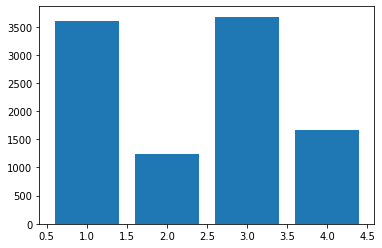

In [63]:
group_sizes = master_significant_gene_progression['progression_group'].value_counts()
plt.bar(group_sizes.index, group_sizes)

In [33]:
master_significant_gene_progression.to_csv(f'{this_figure_dir}/gene_clusters.csv', index=False)

In [34]:
group_order = pd.Series(fit_hierarchical.labels_).value_counts().index

In [35]:
logFC_limits = np.quantile(master_significant_gene_progression[pivot_cols].to_numpy(), [0.0005,0.9995])
logFC_limits

array([-2.5635586 ,  1.88259296])

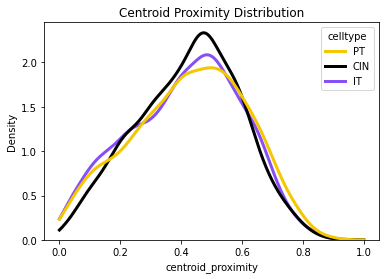

In [36]:
sns.kdeplot(
    data = master_significant_gene_progression[['celltype','centroid_proximity']],
    x='centroid_proximity', hue='celltype', 
    common_norm=False, clip=(0,1),
    hue_order=['PT','CIN','IT'],  palette=[colors_19[0], 'black', colors_19[1]], 
    alpha=1.0, linewidth=3
)
plt.title('Centroid Proximity Distribution')
plt.savefig(f'{this_figure_dir}/proximity_distribution_kde.png', dpi=600)
plt.savefig(f'{this_figure_dir}/proximity_distribution_kde.pdf', dpi=600)

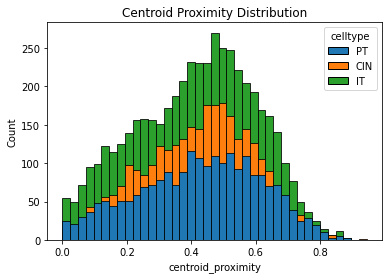

In [37]:
sns.histplot(
    data = master_significant_gene_progression[['celltype','centroid_proximity']],
    x='centroid_proximity', hue='celltype', hue_order=['PT','CIN','IT'],
    alpha=1.0
)
plt.title('Centroid Proximity Distribution')
plt.savefig(f'{this_figure_dir}/proximity_distribution_noalpha.png', dpi=600)
plt.savefig(f'{this_figure_dir}/proximity_distribution_noalpha.pdf', dpi=600)

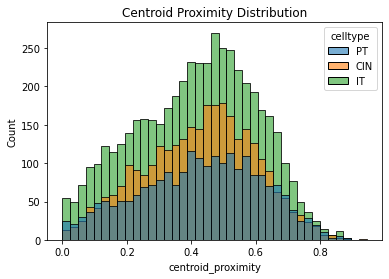

In [38]:
sns.histplot(
    data = master_significant_gene_progression[['celltype','centroid_proximity']],
    x='centroid_proximity', hue='celltype', hue_order=['PT','CIN','IT'],
    alpha=0.6
)
plt.title('Centroid Proximity Distribution')
plt.savefig(f'{this_figure_dir}/proximity_distribution.png', dpi=600)
plt.savefig(f'{this_figure_dir}/proximity_distribution.pdf', dpi=600)

### Plot IT Excitatory

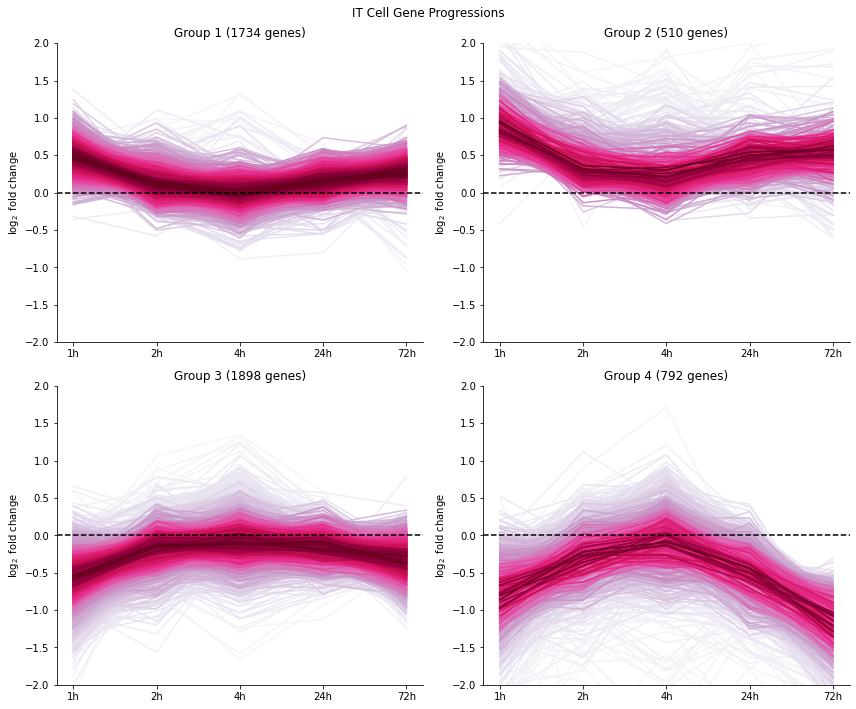

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

for ax, progression_group in zip(axes.flatten(), np.unique(master_significant_gene_progression['progression_group'])):
    
    group_df = master_significant_gene_progression[
        (master_significant_gene_progression['celltype'] == 'IT') &
        (master_significant_gene_progression['progression_group'] == progression_group)]
    num_genes = group_df.shape[0]
    group_df = pd.melt(group_df.reset_index(), id_vars=['index','centroid_proximity'], value_vars=pivot_cols)
    
    sns.lineplot(data=group_df, x='variable', y='value',
                 hue='centroid_proximity', palette='PuRd', legend=False, 
                 ax=ax)
    ax.set_ylim(-2, 2)
    ax.set_title(f'Group {progression_group} ({num_genes} genes)')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel('$\log_2$ fold change')

sns.despine(fig=fig)
fig.suptitle('IT Cell Gene Progressions')
fig.tight_layout()
plt.savefig(f'{this_figure_dir}/IT_gene_clusters.png', dpi=600, transparent=True)
plt.savefig(f'{this_figure_dir}/IT_gene_clusters.pdf', dpi=600, transparent=True)

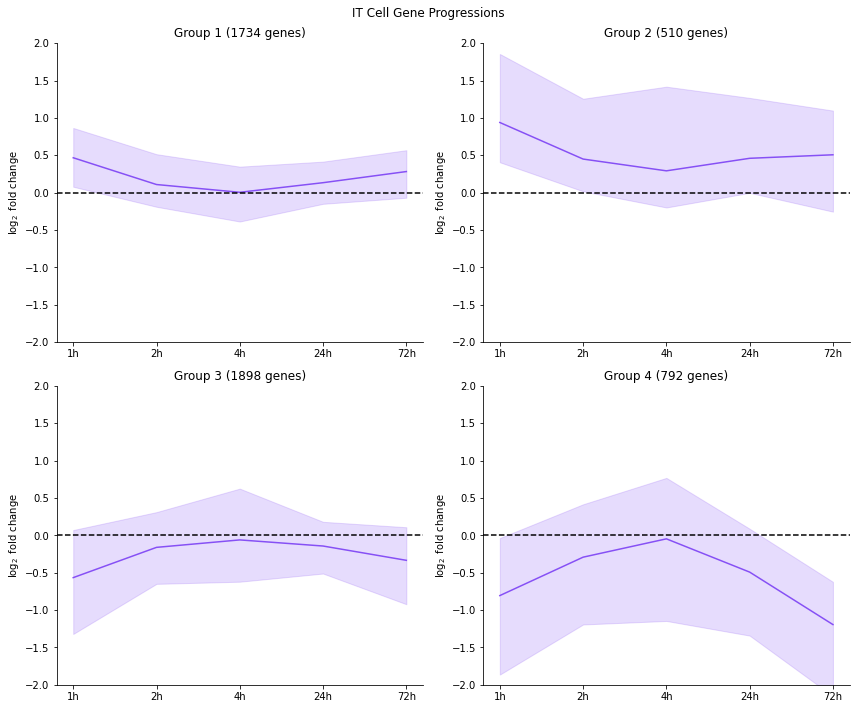

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

for ax, progression_group in zip(axes.flatten(), np.unique(master_significant_gene_progression['progression_group'])):
    group_df = master_significant_gene_progression[
        (master_significant_gene_progression['celltype'] == 'IT') &
        (master_significant_gene_progression['progression_group'] == progression_group)]
    num_genes = group_df.shape[0]
    group_df = pd.melt(group_df.reset_index(), id_vars=['index','centroid_proximity'], value_vars=pivot_cols)
    
    sns.lineplot(data=group_df, x='variable', y='value',
                 estimator='mean', errorbar=('pi',95), err_style='band',
                 color=colors_19[1],
                 ax=ax)
    ax.set_ylim(-2, 2)
    ax.set_title(f'Group {progression_group} ({num_genes} genes)')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel('$\log_2$ fold change')

sns.despine(fig=fig)
fig.suptitle('IT Cell Gene Progressions')
fig.tight_layout()
plt.savefig(f'{this_figure_dir}/IT_gene_clusters_ci.png', dpi=600, transparent=True)
plt.savefig(f'{this_figure_dir}/IT_gene_clusters_ci.pdf', dpi=600, transparent=True)

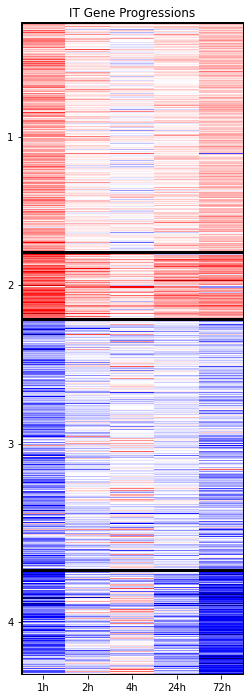

In [41]:
IT_significant_gene_progression = master_significant_gene_progression.query('celltype == "IT"')
IT_heatmap_data = IT_significant_gene_progression.sort_values('progression_group')[pivot_cols]
group_breaks = np.where(np.diff(IT_significant_gene_progression['progression_group'].sort_values()) != 0)[0]
group_breaks = [0] + list(group_breaks) + [IT_significant_gene_progression.shape[0]]
group_ticks = np.convolve(group_breaks, [0.5,0.5], mode='valid')

fig, ax = plt.subplots(1, 1, figsize=(4, 12))
sns.heatmap(
    IT_heatmap_data,
    cmap='seismic', center=0, vmin=logFC_limits[0], vmax=logFC_limits[1],
    cbar=None, robust=True,
    ax = ax
)
ax.set_yticks(ticks=group_ticks, labels=np.sort(np.unique(master_significant_gene_progression['progression_group'])))
ax.set_title('IT Gene Progressions')

for i in range(1, len(group_breaks)):
    rect = plt.Rectangle(
        xy=(0, group_breaks[i-1]), width=len(pivot_cols), height=group_breaks[i]-group_breaks[i-1],
        fill=None, color='black', linewidth=3
    )
    ax.add_patch(rect)
    
plt.savefig(f'{this_figure_dir}/IT_gene_progression_heatmap.png', dpi=600, transparent=True)
plt.savefig(f'{this_figure_dir}/IT_gene_progression_heatmap.pdf', dpi=600, transparent=True)

### Plot CIN

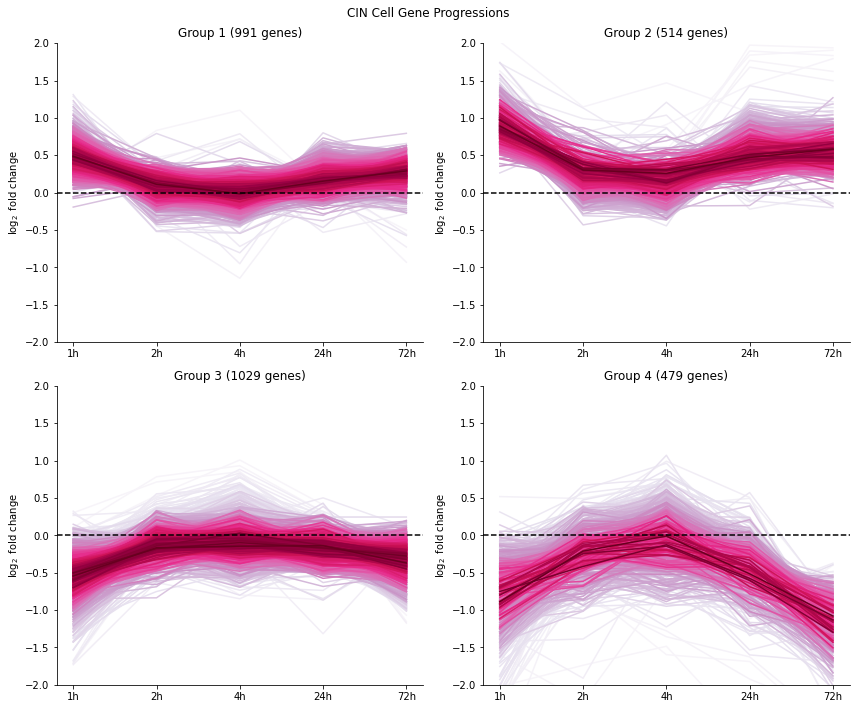

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

for ax, progression_group in zip(axes.flatten(), np.unique(master_significant_gene_progression['progression_group'])):
    group_df = master_significant_gene_progression[
        (master_significant_gene_progression['celltype'] == 'CIN') &
        (master_significant_gene_progression['progression_group'] == progression_group)]
    num_genes = group_df.shape[0]
    group_df = pd.melt(group_df.reset_index(), id_vars=['index','centroid_proximity'], value_vars=pivot_cols)
    
    sns.lineplot(data=group_df, x='variable', y='value',
                 hue='centroid_proximity', palette='PuRd', legend=False, 
                 ax=ax)
    ax.set_ylim(-2, 2)
    ax.set_title(f'Group {progression_group} ({num_genes} genes)')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel('$\log_2$ fold change')

sns.despine(fig=fig)
fig.suptitle('CIN Cell Gene Progressions')
fig.tight_layout()
plt.savefig(f'{this_figure_dir}/cin_gene_clusters.png', dpi=600, transparent=True)
plt.savefig(f'{this_figure_dir}/cin_gene_clusters.pdf', dpi=600, transparent=True)

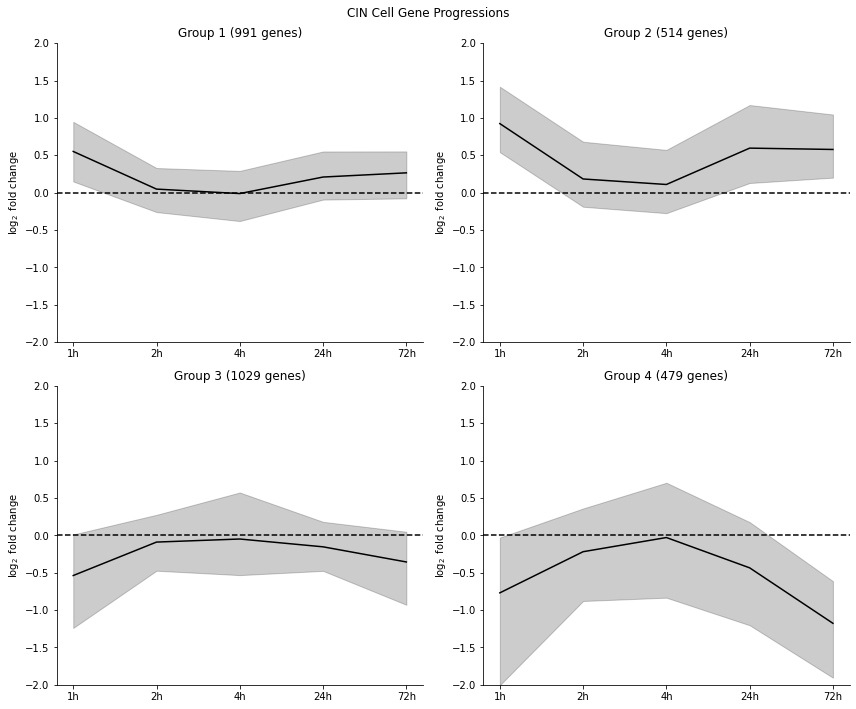

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

for ax, progression_group in zip(axes.flatten(), np.unique(master_significant_gene_progression['progression_group'])):
    group_df = master_significant_gene_progression[
        (master_significant_gene_progression['celltype'] == 'CIN') &
        (master_significant_gene_progression['progression_group'] == progression_group)]
    num_genes = group_df.shape[0]
    group_df = pd.melt(group_df.reset_index(), id_vars=['index','centroid_proximity'], value_vars=pivot_cols)
    
    sns.lineplot(data=group_df, x='variable', y='value',
                 estimator='mean', errorbar=('pi',95), err_style='band',
                 color='black',
                 ax=ax)
    ax.set_ylim(-2, 2)
    ax.set_title(f'Group {progression_group} ({num_genes} genes)')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel('$\log_2$ fold change')

sns.despine(fig=fig)
fig.suptitle('CIN Cell Gene Progressions')
fig.tight_layout()
plt.savefig(f'{this_figure_dir}/cin_gene_clusters_ci.png', dpi=600, transparent=True)
plt.savefig(f'{this_figure_dir}/cin_gene_clusters_ci.pdf', dpi=600, transparent=True)

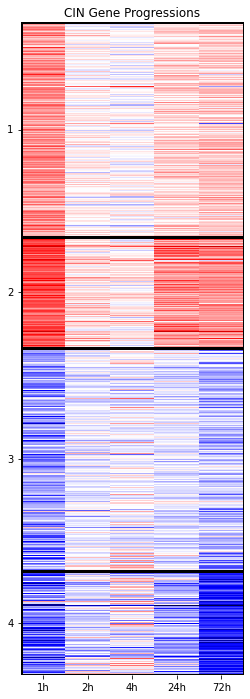

In [44]:
CIN_significant_gene_progression = master_significant_gene_progression.query('celltype == "CIN"')
CIN_heatmap_data = CIN_significant_gene_progression.sort_values('progression_group')[pivot_cols]
group_breaks = np.where(np.diff(CIN_significant_gene_progression['progression_group'].sort_values()) != 0)[0]
group_breaks = [0] + list(group_breaks) + [CIN_significant_gene_progression.shape[0]]
group_ticks = np.convolve(group_breaks, [0.5,0.5], mode='valid')

fig, ax = plt.subplots(1, 1, figsize=(4, 12))
sns.heatmap(
    CIN_heatmap_data,
    cmap='seismic', center=0, vmin=logFC_limits[0], vmax=logFC_limits[1],
    cbar=None, robust=True,
    ax = ax
)
ax.set_yticks(ticks=group_ticks, labels=np.sort(np.unique(master_significant_gene_progression['progression_group'])))
ax.set_title('CIN Gene Progressions')

for i in range(1, len(group_breaks)):
    rect = plt.Rectangle(
        xy=(0, group_breaks[i-1]), width=len(pivot_cols), height=group_breaks[i]-group_breaks[i-1],
        fill=None, color='black', linewidth=3
    )
    ax.add_patch(rect)
    
plt.savefig(f'{this_figure_dir}/CIN_gene_progression_heatmap.png', dpi=600, transparent=True)
plt.savefig(f'{this_figure_dir}/CIN_gene_progression_heatmap.pdf', dpi=600, transparent=True)

### Plot PT excitatory

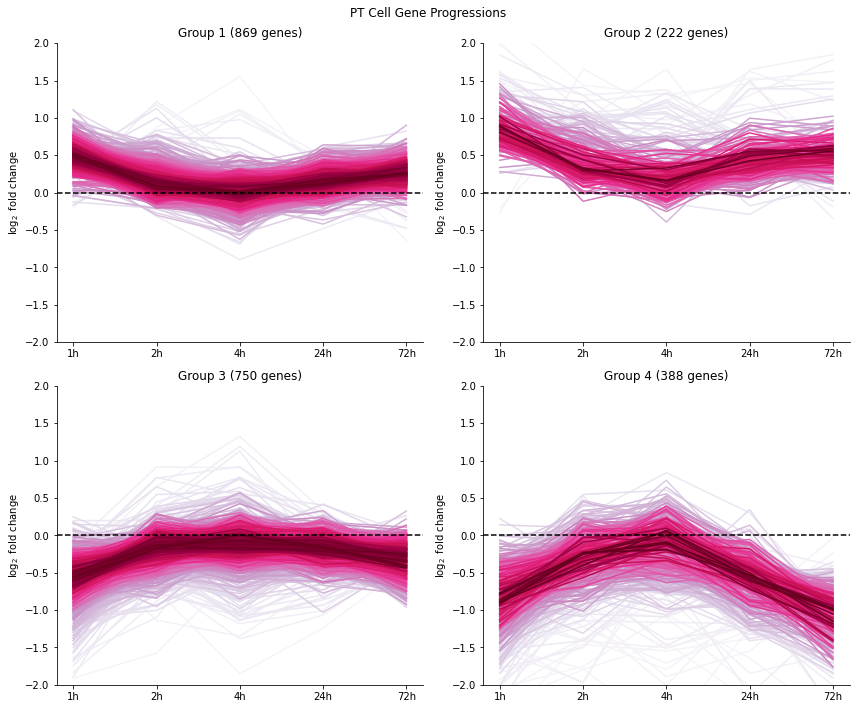

In [45]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

for ax, progression_group in zip(axes.flatten(), np.unique(master_significant_gene_progression['progression_group'])):
    group_df = master_significant_gene_progression[
        (master_significant_gene_progression['celltype'] == 'PT') &
        (master_significant_gene_progression['progression_group'] == progression_group)]
    num_genes = group_df.shape[0]
    group_df = pd.melt(group_df.reset_index(), id_vars=['index','centroid_proximity'], value_vars=pivot_cols)
    
    sns.lineplot(data=group_df, x='variable', y='value',
                 hue='centroid_proximity', palette='PuRd', legend=False, 
                 ax=ax)
    ax.set_ylim(-2, 2)
    ax.set_title(f'Group {progression_group} ({num_genes} genes)')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel('$\log_2$ fold change')

sns.despine(fig=fig)
fig.suptitle('PT Cell Gene Progressions')
fig.tight_layout()
plt.savefig(f'{this_figure_dir}/PT_gene_clusters.png', dpi=600, transparent=True)
plt.savefig(f'{this_figure_dir}/PT_gene_clusters.pdf', dpi=600, transparent=True)

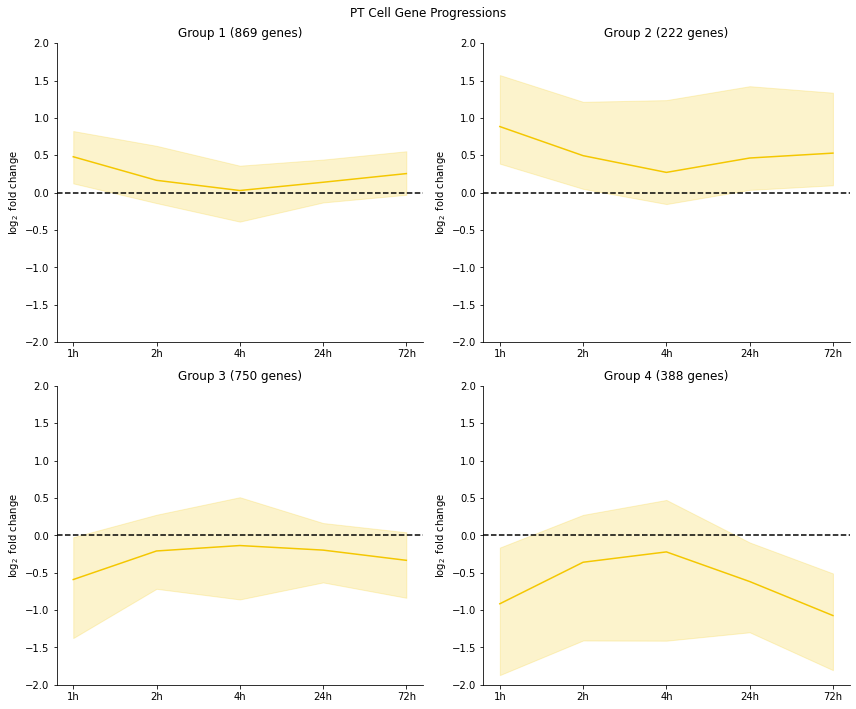

In [69]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

for ax, progression_group in zip(axes.flatten(), np.unique(master_significant_gene_progression['progression_group'])):
    group_df = master_significant_gene_progression[
        (master_significant_gene_progression['celltype'] == 'PT') &
        (master_significant_gene_progression['progression_group'] == progression_group)]
    num_genes = group_df.shape[0]
    group_df = pd.melt(group_df.reset_index(), id_vars=['index','centroid_proximity'], value_vars=pivot_cols)
    
    sns.lineplot(data=group_df, x='variable', y='value',
                 estimator='mean', errorbar=('pi',95), err_style='band',
                 color=colors_19[0],
                 ax=ax)
    ax.set_ylim(-2, 2)
    ax.set_title(f'Group {progression_group} ({num_genes} genes)')
    ax.axhline(0, color='black', linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel('$\log_2$ fold change')

sns.despine(fig=fig)
fig.suptitle('PT Cell Gene Progressions')
fig.tight_layout()
plt.savefig(f'{this_figure_dir}/PT_gene_clusters_ci.png', dpi=600, transparent=True)
plt.savefig(f'{this_figure_dir}/PT_gene_clusters_ci.pdf', dpi=600, transparent=True)

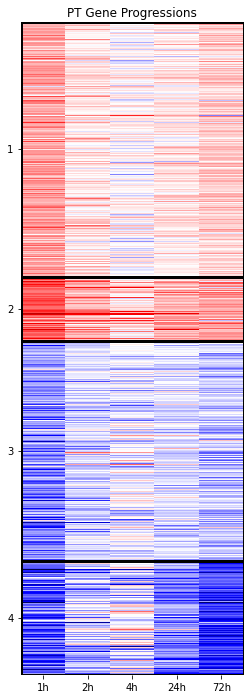

In [47]:
PT_significant_gene_progression = master_significant_gene_progression.query('celltype == "PT"')
PT_heatmap_data = PT_significant_gene_progression.sort_values('progression_group')[pivot_cols]
group_breaks = np.where(np.diff(PT_significant_gene_progression['progression_group'].sort_values()) != 0)[0]
group_breaks = [0] + list(group_breaks) + [PT_significant_gene_progression.shape[0]]
group_ticks = np.convolve(group_breaks, [0.5,0.5], mode='valid')

fig, ax = plt.subplots(1, 1, figsize=(4, 12))
sns.heatmap(
    PT_heatmap_data,
    cmap='seismic', center=0, vmin=logFC_limits[0], vmax=logFC_limits[1],
    cbar=None, robust=True,
    ax = ax
)
ax.set_yticks(ticks=group_ticks, labels=np.sort(np.unique(master_significant_gene_progression['progression_group'])))
ax.set_title('PT Gene Progressions')

for i in range(1, len(group_breaks)):
    rect = plt.Rectangle(
        xy=(0, group_breaks[i-1]), width=len(pivot_cols), height=group_breaks[i]-group_breaks[i-1],
        fill=None, color='black', linewidth=3
    )
    ax.add_patch(rect)
    
plt.savefig(f'{this_figure_dir}/PT_gene_progression_heatmap.png', dpi=600, transparent=True)
plt.savefig(f'{this_figure_dir}/PT_gene_progression_heatmap.pdf', dpi=600, transparent=True)

## Genes that have similar response in both cell types

less relevant with more than 2 groups

In [48]:
master_significant_gene_progression = pd.read_csv(f'{this_figure_dir}/gene_clusters.csv')

In [49]:
# def progression_group_jaccard(df):
#     t1_genes = set(df.query('celltype == "CIN"')['gene'].to_list())
#     t2_genes = set(df.query('celltype == "Excitatory"')['gene'].to_list())
#     return len(t1_genes.intersection(t2_genes)) / len(t1_genes.union(t2_genes))

# progression_group_genelist_similarity = master_significant_gene_progression.groupby('progression_group').apply(progression_group_jaccard)
# print(progression_group_genelist_similarity)

# ax = sns.barplot(data=progression_group_genelist_similarity, color='grey')
# ax.set_title('Jaccard Similarity between CIN & Excitatory')
# ax.set(xlabel='Progression Group', ylabel='Jaccard Similarity')
# plt.savefig(f'{this_figure_dir}/group_similarity_between_celltypes.png', dpi=600, transparent=True)
# plt.savefig(f'{this_figure_dir}/group_similarity_between_celltypes.pdf', dpi=600, transparent=True)

# Colorbars

In [50]:
import matplotlib.colors as mcolors
import matplotlib as mpl

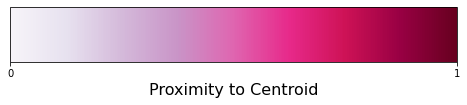

In [51]:
fig, ax = plt.subplots(figsize=(8,2))
fig.subplots_adjust(bottom=0.5)

cmap = "PuRd"
norm = mcolors.Normalize(vmin=0, vmax=1)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
cb1.set_label('Proximity to Centroid', fontsize=16)
ax.set_xticks([0,1])

plt.savefig(f'{this_figure_dir}/proximity_cbar.png', dpi=600, transparent=True)
plt.savefig(f'{this_figure_dir}/proximity_cbar.pdf', dpi=600, transparent=True)

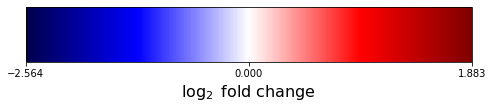

In [52]:
fig, ax = plt.subplots(figsize=(8,2))
fig.subplots_adjust(bottom=0.5)

cmap = "seismic"
norm = mcolors.TwoSlopeNorm(vcenter=0, vmin=logFC_limits[0], vmax=logFC_limits[1],)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
cb1.set_label('$\log_2$ fold change', fontsize=16)
ax.set_xticks([logFC_limits[0], 0, logFC_limits[1]])

plt.savefig(f'{this_figure_dir}/log_fold_cbar.png', dpi=600, transparent=True)
plt.savefig(f'{this_figure_dir}/log_fold_cbar.pdf', dpi=600, transparent=True)